## Modeling *Ironsworn*’s core mechanic in [``dyce``](https://posita.github.io/dyce/)

Select ``Run All Cells`` from the ``Run`` menu above.

In [1]:
# Install additional requirements if necessary
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    try:
        import anydyce
    except (ImportError, ModuleNotFoundError):
        requirements = ["anydyce~=0.1"]
        try:
            import piplite ; await piplite.install(requirements)
        except ImportError:
            import pip ; pip.main(["install"] + requirements)
    import anydyce

In [2]:
from dyce import H
from enum import IntEnum, auto

class IronSoloResult(IntEnum):
    SPECTACULAR_FAILURE = -1
    FAILURE = auto()
    WEAK_SUCCESS = auto()
    STRONG_SUCCESS = auto()
    SPECTACULAR_SUCCESS = auto()

d6 = H(6)
d10 = H(10)

def iron_solo_dependent_term(action, first_challenge, second_challenge, mod=0):
    modded_action = action + mod
    beats_first = modded_action > first_challenge
    beats_second = modded_action > second_challenge
    doubles = first_challenge == second_challenge

    if beats_first and beats_second:
        return (
            IronSoloResult.SPECTACULAR_SUCCESS
            if doubles
            else IronSoloResult.STRONG_SUCCESS
        )
    elif beats_first or beats_second:
        return IronSoloResult.WEAK_SUCCESS
    else:
        return (
            IronSoloResult.SPECTACULAR_FAILURE
            if doubles
            else IronSoloResult.FAILURE
        )

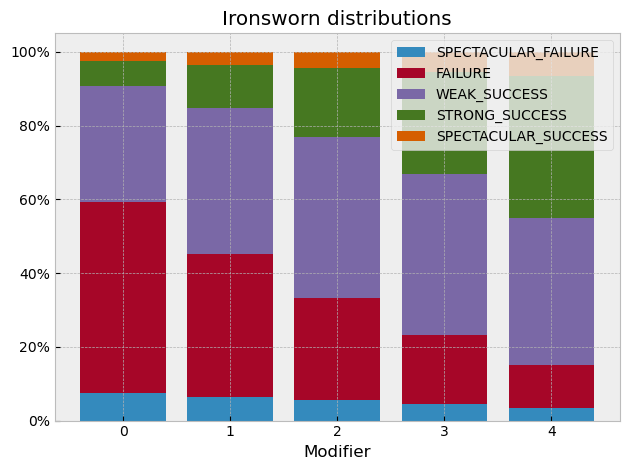

In [3]:
import matplotlib
from collections import defaultdict
from functools import partial

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.style.use("bmh")
ax = matplotlib.pyplot.axes()
by_result = defaultdict(list)
mods = list(range(0, 5))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))

for mod in mods:
    results_for_mod = H.foreach(
        partial(iron_solo_dependent_term, mod=mod),
        action=d6,
        first_challenge=d10,
        second_challenge=d10,
    )
    distribution_for_mod = dict(results_for_mod.distribution())

    for result in IronSoloResult:
        result_val = float(distribution_for_mod.get(result, 0))
        by_result[result].append(result_val)

labels = [str(mod) for mod in mods]
bottoms = [0.0 for _ in mods]

for result in IronSoloResult:
    result_vals = by_result[result]
    assert len(result_vals) == len(mods)
    ax.bar(labels, result_vals, bottom=bottoms, label=result.name)
    bottoms = [
        bottom + result_val for bottom, result_val in zip(bottoms, result_vals)
    ]

ax.legend()
ax.set_xlabel("Modifier")
ax.set_title("Ironsworn distributions")
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [4]:
from anydyce.viz import BreakoutType, jupyter_visualize

jupyter_visualize(
    [
        (f"Modifier: {mod:+}", H.foreach(
            partial(iron_solo_dependent_term, mod=mod),
            action=d6,
            first_challenge=d10,
            second_challenge=d10,
        )) for mod in range(0, 5)
    ],
    default_breakout_type=BreakoutType.BURST,
    default_main_plot_type="bar",
)